In [ ]:
pip install alpaca-py
pip install nltk
pip install vaderSentiment
pip install tensorflow

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

C:\Users\trvrn\.conda\envs\finrl\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [15]:
#View assets in alpaca
import requests
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import os
import pandas as pd
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass


api_key = 'PKEECQOFTN00XC2N9EQ6'
api_secret = 'h1xslxUKlbpJt4Tu4xWRHWiePEOl2Ne90Bq6w6ha'


trading_client = TradingClient(api_key, api_secret, paper=True)

search_params = GetAssetsRequest(asset_class=AssetClass.CRYPTO)
assets = trading_client.get_all_assets(search_params)
assets


url = 'https://paper-api.alpaca.markets'
api_call = '/v2/assets'

headers = {'content-type': 'application/json', 
           'Apca-Api-Key-Id': api_key, 
           'Apca-Api-Secret-Key': api_secret}

response = requests.get(url + api_call, headers=headers)
response = json.loads(response.text)
assets = [dict(item) for item in response]
df = pd.DataFrame.from_records(assets)

In [16]:
##Convert to dataframe
assets_dict = [dict(item) for item in assets]

df = pd.DataFrame.from_records(assets_dict)
df.head(10)

,id,class,exchange,symbol,name,status,tradable,marginable,maintenance_margin_requirement,shortable,easy_to_borrow,fractionable,attributes,min_order_size,min_trade_increment,price_increment
0,68d8f8a4-ef67-470e-ae83-7b32eb1def25,us_equity,OTC,RMESF,Red Metal Resources Ltd. Common Stock,inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
1,668eb247-2679-4ca9-86a6-9a03116fd987,us_equity,OTC,RMETF,Rackla Metals Inc Common Shares,inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
2,588d357f-5b53-4068-b24a-7467b18e09e1,us_equity,OTC,RMGGF,Resolute Mining Ltd Ordinary Shares,inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
3,48142ef4-c63b-4bd4-99a6-944ca07118aa,us_equity,OTC,RMGGY,Resolute Mining Ltd Unsponsored ADR (Austrailia),inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
4,aee72faf-5026-4508-beeb-8accc910a0f2,us_equity,OTC,RMGNF,RHI Magnesita NV Ordinary Shares (Netherlands),inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
5,fe0686cd-e9da-4d19-8406-24aca1e9b3b8,us_equity,OTC,RMGOF,Remgro Limited Ord Ordinary Shares,inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
6,507ba7f5-6a60-4379-823a-f0ad3f8874b2,us_equity,OTC,RMHB,"Rocky Mountain High Brands, Inc. Common Stock",inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
7,fae9b21b-cc2a-4b74-920f-dd953d719afc,us_equity,ARCA,DOGS,Arrow Dogs of the World ETF,inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
8,39af371f-06bb-472a-bbfd-4d99ce88a431,us_equity,NASDAQ,LOGM,"LogMeIn, Inc. Common Stock",inactive,False,False,100,False,False,False,[],NaN,NaN,NaN
9,cb8c49b0-5507-400b-a5a3-f077284690cd,us_equity,NYSE,PPX,"PPL CAPITAL FUNDING, INC. 2013 Series B Junior...",inactive,False,False,100,False,False,False,[],NaN,NaN,NaN


In [21]:
client = CryptoHistoricalDataClient()
client

In [50]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame

# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
                        symbol_or_symbols=["BTC/USD","ETH/USD"],
                        timeframe=TimeFrame.Minute,  # Set to 1-minute intervals
                        start="2023-01-01T00:00:00Z",  # ISO 8601 format for the start date
                        end="2023-10-06T00:00:00Z")  # ISO 8601 format for the end date

bars = client.get_crypto_bars(request_params)

In [118]:
data = bars.df

In [119]:
data.head()

open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2023-01-01 00:00:00+00:00  16526.26  16527.58  16522.40  16526.71   
        2023-01-01 00:01:00+00:00  16526.81  16526.82  16522.53  16522.53   
        2023-01-01 00:02:00+00:00  16521.43  16524.45  16518.27  16519.60   
        2023-01-01 00:03:00+00:00  16520.08  16520.08  16513.80  16517.78   
        2023-01-01 00:04:00+00:00  16517.74  16517.74  16510.37  16514.59   

                                     volume  trade_count          vwap  
symbol  timestamp                                                       
BTC/USD 2023-01-01 00:00:00+00:00  0.501588         32.0  16526.222459  
        2023-01-01 00:01:00+00:00  0.310298         15.0  16526.496182  
        2023-01-01 00:02:00+00:00  1.431526         37.0  16520.893111  
        2023-01-01 00:03:00+00:00  2.233005         28.0  16515.797387  
        2023-01-01 00:04:00+00:00  5.893288         54.0  16512.371553

In [120]:
data.tail()

open       high       low      close  \
symbol  timestamp                                                              
ETH/USD 2023-10-05 23:54:00+00:00  1611.7750  1611.7850  1611.775  1611.7850   
        2023-10-05 23:55:00+00:00  1611.2050  1611.2050  1611.205  1611.2050   
        2023-10-05 23:56:00+00:00  1611.5720  1611.8945  1611.572  1611.7675   
        2023-10-05 23:57:00+00:00  1611.7845  1611.8050  1611.481  1611.7400   
        2023-10-06 00:00:00+00:00  1612.5490  1612.5490  1612.549  1612.5490   

                                   volume  trade_count  vwap  
symbol  timestamp                                             
ETH/USD 2023-10-05 23:54:00+00:00     0.0          0.0   0.0  
        2023-10-05 23:55:00+00:00     0.0          0.0   0.0  
        2023-10-05 23:56:00+00:00     0.0          0.0   0.0  
        2023-10-05 23:57:00+00:00     0.0          0.0   0.0  
        2023-10-06 00:00:00+00:00     0.0          0.0   0.0

In [121]:
data.shape

(781678, 7)

In [122]:
data.sort_values(['timestamp','symbol']).head()

,,open,high,low,close,volume,trade_count,vwap
symbol,timestamp,,,,,,,
BTC/USD,2023-01-01 00:00:00+00:00,16526.26,16527.58,16522.40,16526.71,0.501588,32.0,16526.222459
ETH/USD,2023-01-01 00:00:00+00:00,1195.61,1195.61,1195.27,1195.52,0.071220,7.0,1195.405400
BTC/USD,2023-01-01 00:01:00+00:00,16526.81,16526.82,16522.53,16522.53,0.310298,15.0,16526.496182
ETH/USD,2023-01-01 00:01:00+00:00,1195.60,1195.64,1195.60,1195.64,0.298620,2.0,1195.621834
BTC/USD,2023-01-01 00:02:00+00:00,16521.43,16524.45,16518.27,16519.60,1.431526,37.0,16520.893111


In [123]:
data.head()

open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2023-01-01 00:00:00+00:00  16526.26  16527.58  16522.40  16526.71   
        2023-01-01 00:01:00+00:00  16526.81  16526.82  16522.53  16522.53   
        2023-01-01 00:02:00+00:00  16521.43  16524.45  16518.27  16519.60   
        2023-01-01 00:03:00+00:00  16520.08  16520.08  16513.80  16517.78   
        2023-01-01 00:04:00+00:00  16517.74  16517.74  16510.37  16514.59   

                                     volume  trade_count          vwap  
symbol  timestamp                                                       
BTC/USD 2023-01-01 00:00:00+00:00  0.501588         32.0  16526.222459  
        2023-01-01 00:01:00+00:00  0.310298         15.0  16526.496182  
        2023-01-01 00:02:00+00:00  1.431526         37.0  16520.893111  
        2023-01-01 00:03:00+00:00  2.233005         28.0  16515.797387  
        2023-01-01 00:04:00+00:00  5.893288         54.0  16512.371553

Pre-Process Data

In [61]:
!pip install pandas ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29422 sha256=f95c7a71452ef19b4fc16d906fb00e7e22b9f9aee04975315056ef00360fe9dd
  Stored in directory: c:\users\trvrn\appdata\local\pip\cache\wheels\5f\67\4f\8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [124]:
import pandas as pd
from ta.trend import MACD
from ta.momentum import RSIIndicator

# Assume 'data' is your DataFrame from Alpaca API
# Make sure your DataFrame is sorted by date and includes 'close' prices

# Calculate MACD
macd = MACD(data['close'])
data['macd'] = macd.macd()

# Calculate RSI
rsi = RSIIndicator(data['close'])
data['rsi'] = rsi.rsi()

# Function to calculate the Turbulence Index
def calculate_turbulence(data):
    # Assuming 'data' includes historical prices for multiple assets
    # You will need to adjust this method based on how your data is structured
    # This is a simple example for illustrative purposes
    historical_mean = data['close'].mean()
    historical_std = data['close'].std()
    turbulence = ((data['close'] - historical_mean) / historical_std) ** 2
    return turbulence

# Add Turbulence Index
data['turbulence'] = calculate_turbulence(data)

# Now your data is ready with the technical indicators and the turbulence index


In [125]:
data

open        high        low  \
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00  16526.2600  16527.5800  16522.400   
        2023-01-01 00:01:00+00:00  16526.8100  16526.8200  16522.530   
        2023-01-01 00:02:00+00:00  16521.4300  16524.4500  16518.270   
        2023-01-01 00:03:00+00:00  16520.0800  16520.0800  16513.800   
        2023-01-01 00:04:00+00:00  16517.7400  16517.7400  16510.370   
...                                       ...         ...        ...   
ETH/USD 2023-10-05 23:54:00+00:00   1611.7750   1611.7850   1611.775   
        2023-10-05 23:55:00+00:00   1611.2050   1611.2050   1611.205   
        2023-10-05 23:56:00+00:00   1611.5720   1611.8945   1611.572   
        2023-10-05 23:57:00+00:00   1611.7845   1611.8050   1611.481   
        2023-10-06 00:00:00+00:00   1612.5490   1612.5490   1612.549   

                                        close    volume  trade_count  \
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00  16526.7100  0.501588         32.0   
        2023-01-01 00:01:00+00:00  16522.5300  0.310298         15.0   
        2023-01-01 00:02:00+00:00  16519.6000  1.431526         37.0   
        2023-01-01 00:03:00+00:00  16517.7800  2.233005         28.0   
        2023-01-01 00:04:00+00:00  16514.5900  5.893288         54.0   
...                                       ...       ...          ...   
ETH/USD 2023-10-05 23:54:00+00:00   1611.7850  0.000000          0.0   
        2023-10-05 23:55:00+00:00   1611.2050  0.000000          0.0   
        2023-10-05 23:56:00+00:00   1611.7675  0.000000          0.0   
        2023-10-05 23:57:00+00:00   1611.7400  0.000000          0.0   
        2023-10-06 00:00:00+00:00   1612.5490  0.000000          0.0   

                                           vwap      macd        rsi  \
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00  16526.222459       NaN        NaN   
        2023-01-01 00:01:00+00:00  16526.496182       NaN        NaN   
        2023-01-01 00:02:00+00:00  16520.893111       NaN        NaN   
        2023-01-01 00:03:00+00:00  16515.797387       NaN        NaN   
        2023-01-01 00:04:00+00:00  16512.371553       NaN        NaN   
...                                         ...       ...        ...   
ETH/USD 2023-10-05 23:54:00+00:00      0.000000 -0.993577  36.160839   
        2023-10-05 23:55:00+00:00      0.000000 -1.041199  33.457103   
        2023-10-05 23:56:00+00:00      0.000000 -1.021773  38.277146   
        2023-10-05 23:57:00+00:00      0.000000 -0.997102  38.131724   
        2023-10-06 00:00:00+00:00      0.000000 -0.901874  44.778345   

                                   turbulence  
symbol  timestamp                              
BTC/USD 2023-01-01 00:00:00+00:00    0.040428  
        2023-01-01 00:01:00+00:00    0.040294  
        2023-01-01 00:02:00+00:00    0.040200  
        2023-01-01 00:03:00+00:00    0.040142  
        2023-01-01 00:04:00+00:00    0.040040  
...                                       ...  
ETH/USD 2023-10-05 23:54:00+00:00    0.976782  
        2023-10-05 23:55:00+00:00    0.976873  
        2023-10-05 23:56:00+00:00    0.976785  
        2023-10-05 23:57:00+00:00    0.976789  
        2023-10-06 00:00:00+00:00    0.976662  

[781678 rows x 10 columns]

In [126]:
from ta.volatility import AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator

# Assuming you have already read your dataframe from the image provided
# This is just a placeholder for the actual dataframe you have
df = pd.DataFrame()

# Since MACD and RSI are already included, we'll calculate ATR and OBV as additional indicators

# Calculate Average True Range (ATR) for volatility
atr = AverageTrueRange(high=data['high'], low=data['low'], close=data['close'], window=14)
data['atr'] = atr.average_true_range()

# Calculate On-Balance Volume (OBV) for volume trend
obv = OnBalanceVolumeIndicator(close=data['close'], volume=data['volume'])
data['obv'] = obv.on_balance_volume()

# Your dataframe now includes ATR and OBV along with the existing MACD and RSI
# You would continue your preprocessing from here, such as handling NaN values, etc.

data.head()  # Show the first few rows of the dataframe



open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2023-01-01 00:00:00+00:00  16526.26  16527.58  16522.40  16526.71   
        2023-01-01 00:01:00+00:00  16526.81  16526.82  16522.53  16522.53   
        2023-01-01 00:02:00+00:00  16521.43  16524.45  16518.27  16519.60   
        2023-01-01 00:03:00+00:00  16520.08  16520.08  16513.80  16517.78   
        2023-01-01 00:04:00+00:00  16517.74  16517.74  16510.37  16514.59   

                                     volume  trade_count          vwap  macd  \
symbol  timestamp                                                              
BTC/USD 2023-01-01 00:00:00+00:00  0.501588         32.0  16526.222459   NaN   
        2023-01-01 00:01:00+00:00  0.310298         15.0  16526.496182   NaN   
        2023-01-01 00:02:00+00:00  1.431526         37.0  16520.893111   NaN   
        2023-01-01 00:03:00+00:00  2.233005         28.0  16515.797387   NaN   
        2023-01-01 00:04:00+00:00  5.893288         54.0  16512.371553   NaN   

                                   rsi  turbulence  atr       obv  
symbol  timestamp                                                  
BTC/USD 2023-01-01 00:00:00+00:00  NaN    0.040428  0.0  0.501588  
        2023-01-01 00:01:00+00:00  NaN    0.040294  0.0  0.191290  
        2023-01-01 00:02:00+00:00  NaN    0.040200  0.0 -1.240236  
        2023-01-01 00:03:00+00:00  NaN    0.040142  0.0 -3.473241  
        2023-01-01 00:04:00+00:00  NaN    0.040040  0.0 -9.366529

In [127]:
# Assuming 'df' is your DataFrame that you have read from the image

# Handle NaN values
data.fillna(method='bfill', inplace=True)  # Backfill NaN values

# Calculate ATR and OBV if not already present
atr = AverageTrueRange(high=data['high'], low=data['low'], close=data['close'])
data['atr'] = atr.average_true_range()

obv = OnBalanceVolumeIndicator(close=data['close'], volume=data['volume'])
data['obv'] = obv.on_balance_volume()

In [128]:
data

open        high        low  \
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00  16526.2600  16527.5800  16522.400   
        2023-01-01 00:01:00+00:00  16526.8100  16526.8200  16522.530   
        2023-01-01 00:02:00+00:00  16521.4300  16524.4500  16518.270   
        2023-01-01 00:03:00+00:00  16520.0800  16520.0800  16513.800   
        2023-01-01 00:04:00+00:00  16517.7400  16517.7400  16510.370   
...                                       ...         ...        ...   
ETH/USD 2023-10-05 23:54:00+00:00   1611.7750   1611.7850   1611.775   
        2023-10-05 23:55:00+00:00   1611.2050   1611.2050   1611.205   
        2023-10-05 23:56:00+00:00   1611.5720   1611.8945   1611.572   
        2023-10-05 23:57:00+00:00   1611.7845   1611.8050   1611.481   
        2023-10-06 00:00:00+00:00   1612.5490   1612.5490   1612.549   

                                        close    volume  trade_count  \
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00  16526.7100  0.501588         32.0   
        2023-01-01 00:01:00+00:00  16522.5300  0.310298         15.0   
        2023-01-01 00:02:00+00:00  16519.6000  1.431526         37.0   
        2023-01-01 00:03:00+00:00  16517.7800  2.233005         28.0   
        2023-01-01 00:04:00+00:00  16514.5900  5.893288         54.0   
...                                       ...       ...          ...   
ETH/USD 2023-10-05 23:54:00+00:00   1611.7850  0.000000          0.0   
        2023-10-05 23:55:00+00:00   1611.2050  0.000000          0.0   
        2023-10-05 23:56:00+00:00   1611.7675  0.000000          0.0   
        2023-10-05 23:57:00+00:00   1611.7400  0.000000          0.0   
        2023-10-06 00:00:00+00:00   1612.5490  0.000000          0.0   

                                           vwap      macd        rsi  \
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00  16526.222459 -0.452813  21.887619   
        2023-01-01 00:01:00+00:00  16526.496182 -0.452813  21.887619   
        2023-01-01 00:02:00+00:00  16520.893111 -0.452813  21.887619   
        2023-01-01 00:03:00+00:00  16515.797387 -0.452813  21.887619   
        2023-01-01 00:04:00+00:00  16512.371553 -0.452813  21.887619   
...                                         ...       ...        ...   
ETH/USD 2023-10-05 23:54:00+00:00      0.000000 -0.993577  36.160839   
        2023-10-05 23:55:00+00:00      0.000000 -1.041199  33.457103   
        2023-10-05 23:56:00+00:00      0.000000 -1.021773  38.277146   
        2023-10-05 23:57:00+00:00      0.000000 -0.997102  38.131724   
        2023-10-06 00:00:00+00:00      0.000000 -0.901874  44.778345   

                                   turbulence       atr           obv  
symbol  timestamp                                                      
BTC/USD 2023-01-01 00:00:00+00:00    0.040428  0.000000      0.501588  
        2023-01-01 00:01:00+00:00    0.040294  0.000000      0.191290  
        2023-01-01 00:02:00+00:00    0.040200  0.000000     -1.240236  
        2023-01-01 00:03:00+00:00    0.040142  0.000000     -3.473241  
        2023-01-01 00:04:00+00:00    0.040040  0.000000     -9.366529  
...                                       ...       ...           ...  
ETH/USD 2023-10-05 23:54:00+00:00    0.976782  0.677705 -31000.893112  
        2023-10-05 23:55:00+00:00    0.976873  0.670726 -31000.893112  
        2023-10-05 23:56:00+00:00    0.976785  0.672067 -31000.893112  
        2023-10-05 23:57:00+00:00    0.976789  0.647205 -31000.893112  
        2023-10-06 00:00:00+00:00    0.976662  0.658762 -31000.893112  

[781678 rows x 12 columns]

In [129]:
# The code below is to check for missing values in the dataframe.
# Please note that to run this code, you must replace 'df' with your actual dataframe variable.

# Check for missing values in each column
missing_values = data.isnull().sum()

# Check for any missing values in the dataframe
missing_values_any = data.isnull().any(axis=1).sum()

# The output will be the count of missing values per column and the total number of rows with missing values
(missing_values, missing_values_any)


(open           0
 high           0
 low            0
 close          0
 volume         0
 trade_count    0
 vwap           0
 macd           0
 rsi            0
 turbulence     0
 atr            0
 obv            0
 dtype: int64,
 0)

In [130]:
# Check for missing values in each column
missing_values = data.isnull().sum()

# Display the missing values for each column
print(missing_values)

# Check for any missing values in the dataframe
missing_values_any = data.isnull().any(axis=1).sum()

# Display the total number of rows with missing values
print(f'Total rows with any missing values: {missing_values_any}')

open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
macd           0
rsi            0
turbulence     0
atr            0
obv            0
dtype: int64
Total rows with any missing values: 0


In [131]:
from sklearn.preprocessing import StandardScaler


# Create a StandardScaler object
scaler = StandardScaler()

# List of columns to scale
columns_to_scale = ['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'macd', 'rsi', 'turbulence', 'atr', 'obv']

# Apply the scaler to the dataframe
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# The dataframe 'data' now has scaled values for the specified columns


In [132]:
data.sample(5)

open      high       low     close  \
symbol  timestamp                                                           
ETH/USD 2023-06-15 23:35:00+00:00 -0.984176 -0.984199 -0.984157 -0.984166   
        2023-05-21 18:48:00+00:00 -0.972586 -0.972555 -0.972518 -0.972535   
        2023-03-01 05:46:00+00:00 -0.985286 -0.985342 -0.985343 -0.985363   
        2023-01-03 04:53:00+00:00 -1.020123 -1.020160 -1.020078 -1.020108   
BTC/USD 2023-02-12 18:03:00+00:00  0.636461  0.635770  0.636721  0.636216   

                                     volume  trade_count      vwap      macd  \
symbol  timestamp                                                              
ETH/USD 2023-06-15 23:35:00+00:00 -0.340792    -0.429754 -0.735975  0.008512   
        2023-05-21 18:48:00+00:00 -0.281986    -0.399759 -0.579849  0.017345   
        2023-03-01 05:46:00+00:00  0.447569    -0.029820 -0.593726 -0.010626   
        2023-01-03 04:53:00+00:00 -0.335325    -0.409758 -0.631325 -0.004820   
BTC/USD 2023-02-12 18:03:00+00:00 -0.280652    -0.159799  1.160640 -0.219016   

                                        rsi  turbulence       atr       obv  
symbol  timestamp                                                            
ETH/USD 2023-06-15 23:35:00+00:00  0.608916   -0.094784 -0.343157 -1.466607  
        2023-05-21 18:48:00+00:00  0.832270   -0.163443 -0.350790 -1.176179  
        2023-03-01 05:46:00+00:00 -0.718344   -0.087671 -0.343299  2.591496  
        2023-01-03 04:53:00+00:00 -1.412039    0.122547 -0.374017  0.097321  
BTC/USD 2023-02-12 18:03:00+00:00 -1.104683   -1.795748 -0.029817  0.671002

Machine Learnign training

 Anomally detection

In [77]:
from sklearn.ensemble import IsolationForest

# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
data['anomaly'] = iso_forest.fit_predict(data[columns_to_scale])

1. Sentiment analysis
2. Anomaly detection

In [133]:
import http.client
import urllib.parse
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to fetch news from MarketAux(Check twitter)
def fetch_market_aux_news(api_token, symbols, limit=50):
    conn = http.client.HTTPSConnection('api.marketaux.com')
    params = urllib.parse.urlencode({
        'api_token': api_token,
        'symbols': symbols,
        'limit': limit,
    })

    conn.request('GET', f'/v1/news/all?{params}')
    res = conn.getresponse()
    data = res.read()

    # Parse the response to JSON
    news_data = json.loads(data.decode('utf-8'))
    return news_data

# Function to analyze sentiment
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# API token for MarketAux
api_token = 'S5gfAVqVw0xrVt28aXULc28tfwZdnoCvjJipdua6'

# Fetch news data
news_data = fetch_market_aux_news(api_token, 'BTC,ETH,USD,CRYPTO,FOREX')

# Initialize a list to hold sentiment scores
sentiments = []

# Perform sentiment analysis on each news item
if 'data' in news_data:
    for news_item in news_data['data']:
        headline = news_item.get('title', '')
        description = news_item.get('description', '')
        text = headline + ' ' + description  # Combine headline and description
        sentiment_score = analyze_sentiment(text)
        sentiments.append(sentiment_score)
        print(f"News: {headline}\nSentiment Score: {sentiment_score}\n")
else:
    print("Failed to retrieve news")

# Convert the list of sentiments to a DataFrame
sentiment_df = pd.DataFrame(sentiments, columns=['sentiment_score'])

# Anomaly Detection with Isolation Forest on sentiment scores
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
sentiment_df['anomaly'] = iso_forest.fit_predict(sentiment_df[['sentiment_score']])

# Display the sentiment scores along with anomaly detection results
print(sentiment_df)


News: Ethan Allen Interiors Inc. (NYSE:ETD) Q1 2024 Earnings Call Transcript
Sentiment Score: 0.802

News: Ethan Allen Interiors Inc. (ETD) Q1 2024 Earnings Call Transcript
Sentiment Score: 0.0

News: Ethan Allen Interiors Inc (ETD) Reports Q1 Fiscal 2024 Results Amid Economic Challenges
Sentiment Score: 0.128

   sentiment_score  anomaly
0            0.802        1
1            0.000        1
2            0.128        1


In [134]:
data

open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2023-01-01 00:00:00+00:00  0.200871  0.200421  0.201221  0.201067   
        2023-01-01 00:01:00+00:00  0.200915  0.200361  0.201232  0.200734   
        2023-01-01 00:02:00+00:00  0.200486  0.200172  0.200892  0.200500   
        2023-01-01 00:03:00+00:00  0.200378  0.199823  0.200535  0.200355   
        2023-01-01 00:04:00+00:00  0.200192  0.199637  0.200262  0.200101   
...                                     ...       ...       ...       ...   
ETH/USD 2023-10-05 23:54:00+00:00 -0.988333 -0.988393 -0.988273 -0.988323   
        2023-10-05 23:55:00+00:00 -0.988378 -0.988440 -0.988318 -0.988370   
        2023-10-05 23:56:00+00:00 -0.988349 -0.988385 -0.988289 -0.988325   
        2023-10-05 23:57:00+00:00 -0.988332 -0.988392 -0.988296 -0.988327   
        2023-10-06 00:00:00+00:00 -0.988271 -0.988332 -0.988211 -0.988263   

                                     volume  trade_count      vwap      macd  \
symbol  timestamp                                                              
BTC/USD 2023-01-01 00:00:00+00:00 -0.327005    -0.109807  0.689703 -0.008866   
        2023-01-01 00:01:00+00:00 -0.332263    -0.279779  0.689727 -0.008866   
        2023-01-01 00:02:00+00:00 -0.301444    -0.059815  0.689243 -0.008866   
        2023-01-01 00:03:00+00:00 -0.279414    -0.149800  0.688804 -0.008866   
        2023-01-01 00:04:00+00:00 -0.178804     0.110157  0.688508 -0.008866   
...                                     ...          ...       ...       ...   
ETH/USD 2023-10-05 23:54:00+00:00 -0.340792    -0.429754 -0.735975 -0.023879   
        2023-10-05 23:55:00+00:00 -0.340792    -0.429754 -0.735975 -0.025201   
        2023-10-05 23:56:00+00:00 -0.340792    -0.429754 -0.735975 -0.024662   
        2023-10-05 23:57:00+00:00 -0.340792    -0.429754 -0.735975 -0.023977   
        2023-10-06 00:00:00+00:00 -0.340792    -0.429754 -0.735975 -0.021333   

                                        rsi  turbulence       atr       obv  
symbol  timestamp                                                            
BTC/USD 2023-01-01 00:00:00+00:00 -2.772543   -2.894933 -0.381605  0.480577  
        2023-01-01 00:01:00+00:00 -2.772543   -2.895337 -0.381605  0.480558  
        2023-01-01 00:02:00+00:00 -2.772543   -2.895620 -0.381605  0.480468  
        2023-01-01 00:03:00+00:00 -2.772543   -2.895796 -0.381605  0.480328  
        2023-01-01 00:04:00+00:00 -2.772543   -2.896103 -0.381605  0.479957  
...                                     ...         ...       ...       ...  
ETH/USD 2023-10-05 23:54:00+00:00 -1.371846   -0.070042 -0.362477 -1.467210  
        2023-10-05 23:55:00+00:00 -1.637176   -0.069767 -0.362674 -1.467210  
        2023-10-05 23:56:00+00:00 -1.164163   -0.070034 -0.362636 -1.467210  
        2023-10-05 23:57:00+00:00 -1.178434   -0.070021 -0.363338 -1.467210  
        2023-10-06 00:00:00+00:00 -0.526170   -0.070406 -0.363011 -1.467210  

[781678 rows x 12 columns]

3. Time Series (LSTM model)

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

In [147]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

In [148]:
# Split into training and test sets
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [149]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [150]:
# Reshape into X=t and Y=t+1
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [151]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [155]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
523722/523722 - 804s - loss: 7.6792e-05 - 804s/epoch - 2ms/step
Epoch 2/100
523722/523722 - 659s - loss: 3.5844e-06 - 659s/epoch - 1ms/step
Epoch 3/100
523722/523722 - 628s - loss: 3.2444e-06 - 628s/epoch - 1ms/step
Epoch 4/100
523722/523722 - 618s - loss: 3.0888e-06 - 618s/epoch - 1ms/step
Epoch 5/100
523722/523722 - 662s - loss: 2.9385e-06 - 662s/epoch - 1ms/step
Epoch 6/100
523722/523722 - 637s - loss: 2.8297e-06 - 637s/epoch - 1ms/step
Epoch 7/100
523722/523722 - 688s - loss: 2.7759e-06 - 688s/epoch - 1ms/step
Epoch 8/100
523722/523722 - 694s - loss: 2.7271e-06 - 694s/epoch - 1ms/step
Epoch 9/100
523722/523722 - 634s - loss: 2.6758e-06 - 634s/epoch - 1ms/step
Epoch 10/100
523722/523722 - 626s - loss: 2.6587e-06 - 626s/epoch - 1ms/step
Epoch 11/100
523722/523722 - 628s - loss: 2.6474e-06 - 628s/epoch - 1ms/step
Epoch 12/100
523722/523722 - 628s - loss: 2.6106e-06 - 628s/epoch - 1ms/step
Epoch 13/100
523722/523722 - 625s - loss: 2.5861e-06 - 625s/epoch - 1ms/step
Epoch 14

In [156]:
# Save the model
model.save('my_lstm_model.h5')  # This saves the model in HDF5 format

In [157]:
# Later, you can load the model using:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_lstm_model.h5')

In [158]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

8061/8061 [==============================] - 9s 1ms/step


In [159]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [162]:
# Calculate MAE, MSE, RMSE for train data
train_mae = mean_absolute_error(Y_train[0], train_predict[:,0])
train_mse = mean_squared_error(Y_train[0], train_predict[:,0])
train_rmse = math.sqrt(train_mse)

In [163]:
# Calculate MAE, MSE, RMSE for test data
test_mae = mean_absolute_error(Y_test[0], test_predict[:,0])
test_mse = mean_squared_error(Y_test[0], test_predict[:,0])
test_rmse = math.sqrt(test_mse)

In [164]:
print(f"Train MAE: {train_mae}, Train MSE: {train_mse}, Train RMSE: {train_rmse}")
print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test RMSE: {test_rmse}")

Train MAE: 0.0030750789577527215, Train MSE: 2.2190937508667675e-05, Train RMSE: 0.004710725794255878
Test MAE: 0.0014538374737523467, Test MSE: 2.8209584776094137e-06, Test RMSE: 0.0016795709206846295


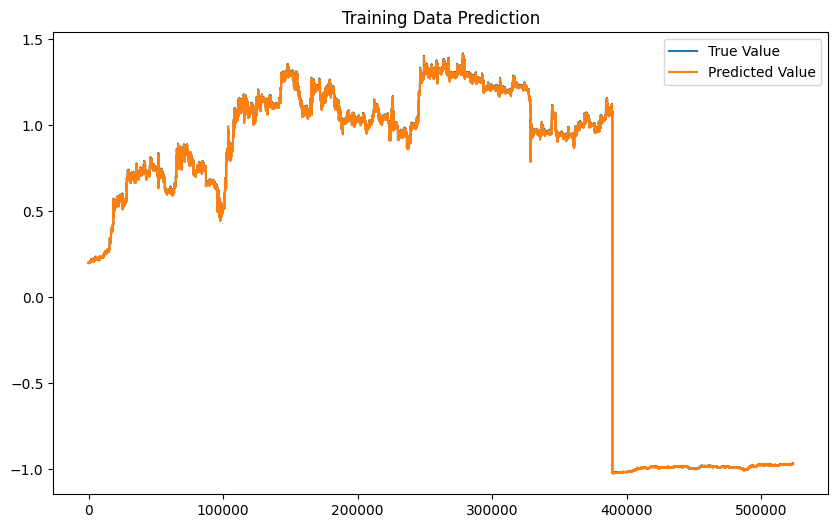

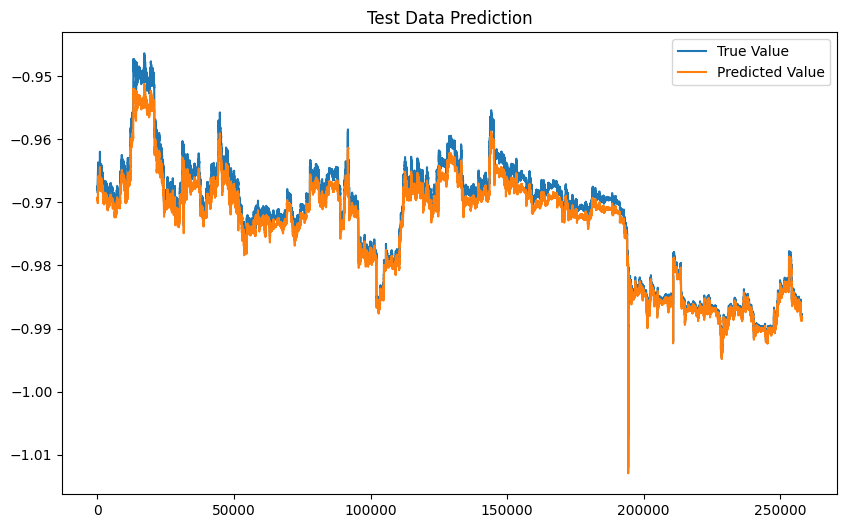

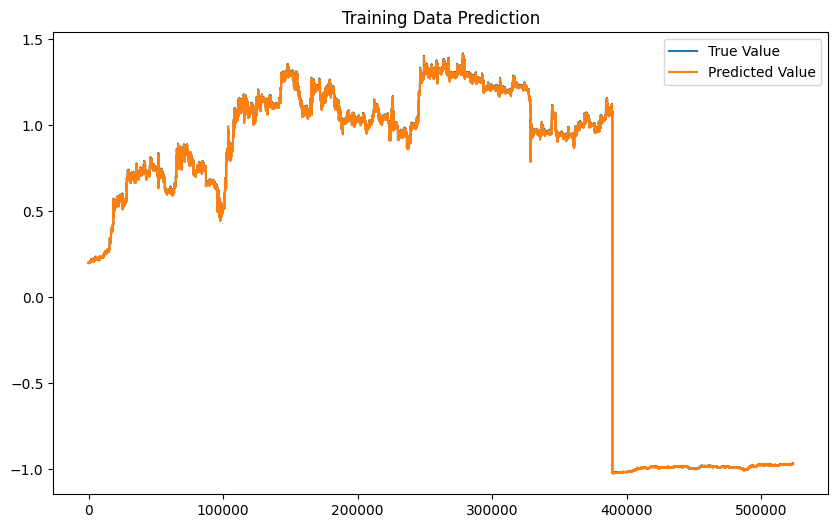

In [170]:
# Visualization of Predictions
plt.figure(figsize=(10,6))
plt.plot(Y_train[0], label='True Value')
plt.plot(train_predict[:,0], label='Predicted Value')
plt.title('Training Data Prediction')
plt.legend()
plt.show()

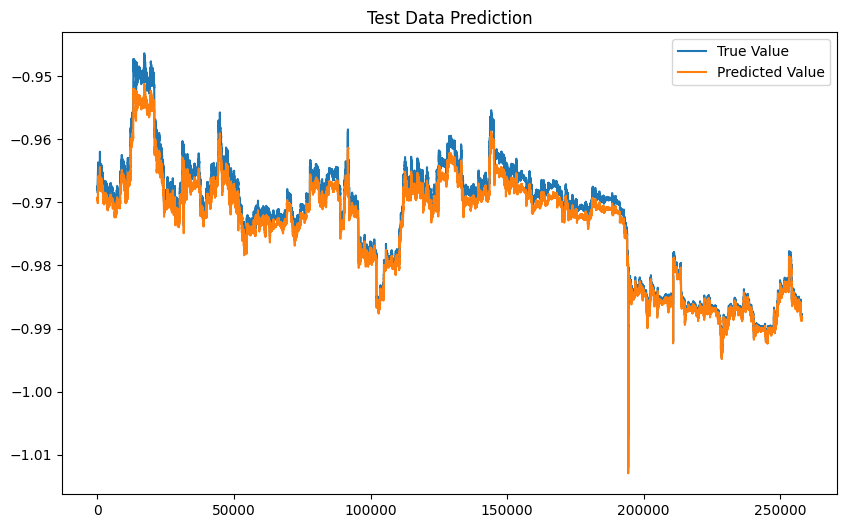

In [171]:
plt.figure(figsize=(10,6))
plt.plot(Y_test[0], label='True Value')
plt.plot(test_predict[:,0], label='Predicted Value')
plt.title('Test Data Prediction')
plt.legend()
plt.show()

In [222]:
# Reset index to turn MultiIndex into columns
data_new = data.reset_index()

# Assuming 'data' is your original trading dataset
# Integrate LSTM forecasts into your dataset
# This is a conceptual example; actual implementation may vary
data_new['LSTM_forecast'] = np.nan
data_new.loc[data_new.index[:len(train_predict)], 'LSTM_forecast'] = train_predict.ravel()
data_new.loc[data_new.index[-len(test_predict):], 'LSTM_forecast'] = test_predict.ravel()

In [209]:
# Specify the file path where you want to save the CSV file
file_path = 'output_new_data.csv'

# Write the DataFrame to a CSV file
data_new.to_csv(file_path, index=False)

In [223]:
# Impute NaN values in the 'LSTM_forecast' column with the mean
mean_value = data_new['LSTM_forecast'].mean()
data_new['LSTM_forecast'].fillna(mean_value, inplace=True)

4. BackTest Strategy

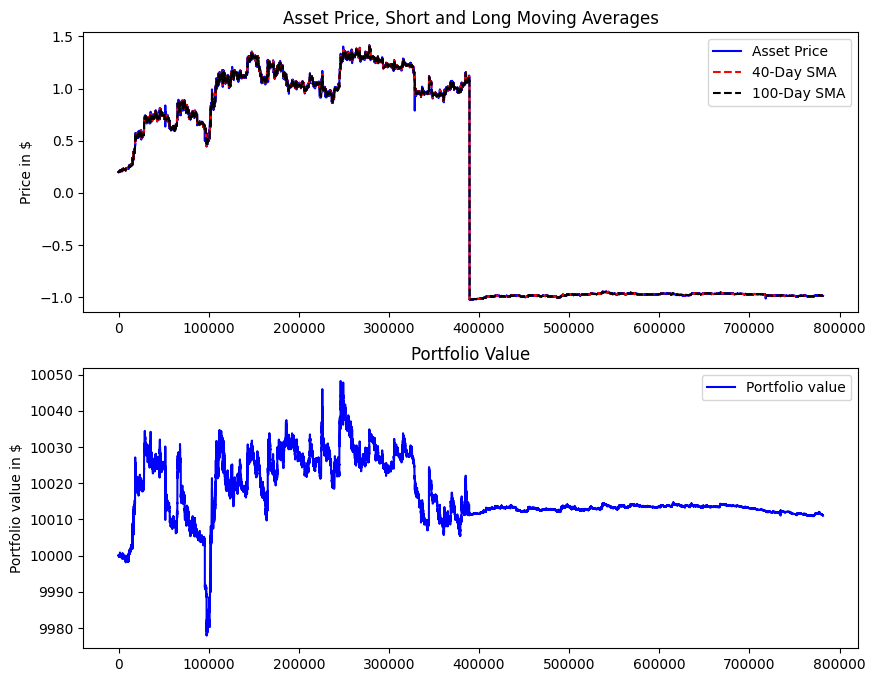

Final Portfolio Value: 10011.05293754711
Total Returns: 0.11%


In [225]:
# Calculate short and long simple moving averages
short_window = 40
long_window = 100

data_new['short_mavg'] = data_new['close'].rolling(window=short_window, min_periods=1).mean()
data_new['long_mavg'] = data_new['close'].rolling(window=long_window, min_periods=1).mean()

# Initialize the signals DataFrame with the signal column
signals = pd.DataFrame(index=data_new.index)
signals['signal'] = 0.0

# Create signals
signals['signal'][short_window:] = np.where(data_new['short_mavg'][short_window:] 
                                            > data_new['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Initialize portfolio with $10,000 using the signals
initial_capital= float(10000.0)
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['BTC/USD'] = 100*signals['signal']   
portfolio = positions.multiply(data_new['close'], axis=0)

# Initialize the portfolio with value owned   
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(data_new['close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(data_new['close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Plot the portfolio value over time, as well as the moving averages and buy/sell signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Plot the asset price
ax1.plot(data_new['close'], label='Asset Price', color='blue')
ax1.plot(data_new['short_mavg'], label='40-Day SMA', color='red', linestyle="--")
ax1.plot(data_new['long_mavg'], label='100-Day SMA', color='black', linestyle="--")
ax1.set_title('Asset Price, Short and Long Moving Averages')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')

# Plot the portfolio value
ax2.plot(portfolio['total'], label='Portfolio value', color='blue')
ax2.set_title('Portfolio Value')
ax2.set_ylabel('Portfolio value in $')
ax2.legend(loc='best')

plt.show()


In [243]:

print(f"Final Portfolio Value: {portfolio['total'].iloc[-1]}")
print(f"Total Returns: {portfolio['returns'].sum()*100:.2f}%")

Final Portfolio Value: 10011.05293754711
Total Returns: 0.11%


4. Setting Up DRL:
Define a custom environment for trading in a framework like OpenAI Gym.
Your state space should include price data, sentiment scores, anomaly detection results, and time series forecasts.
Implement a DRL algorithm like PPO or DDPG using Stable Baselines3.
Train the DRL model on your dataset.
5. Backtesting and Evaluation:
Backtest your model against historical data.
Use various financial metrics to evaluate the performance of your model.
6. Deployment:
After thorough testing and evaluation, deploy your model for paper trading.
Monitor its performance and make necessary adjustments.

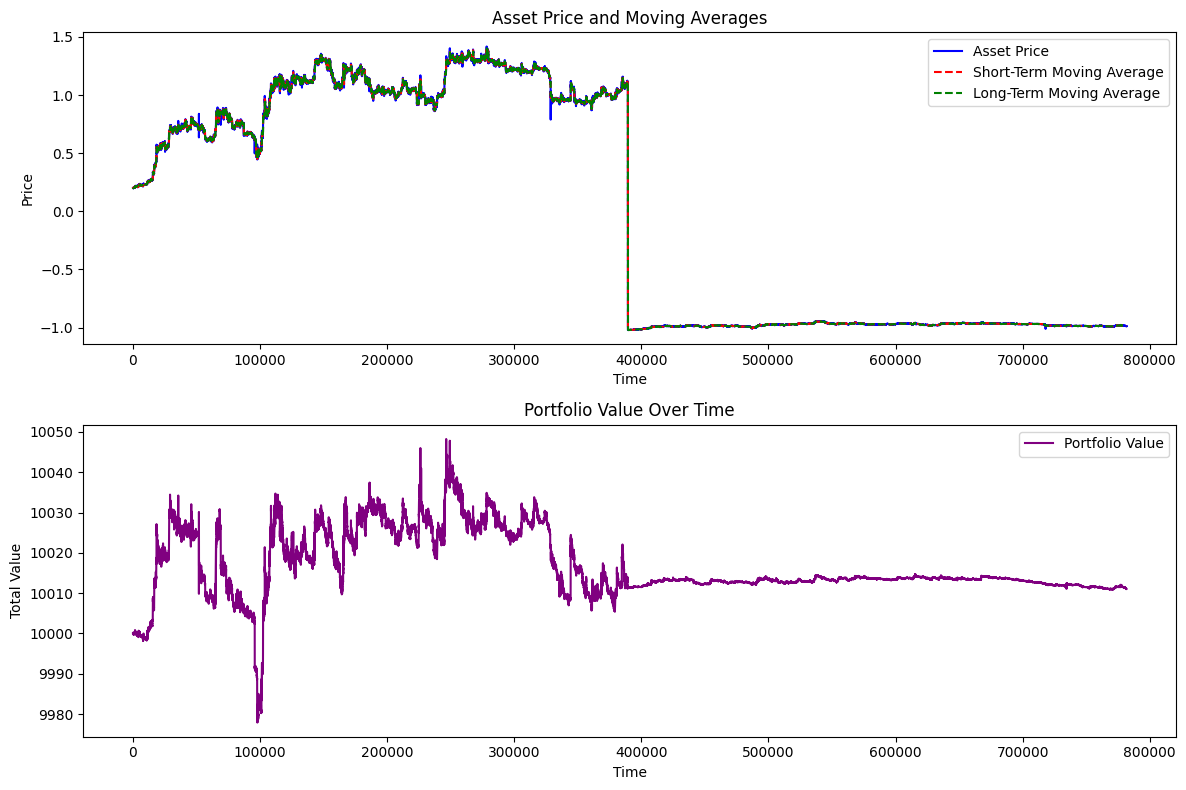

In [244]:
import matplotlib.pyplot as plt

# Plotting asset price and moving averages
plt.figure(figsize=(12, 8))

# Asset price
plt.subplot(2, 1, 1)
plt.plot(data_new['close'], label='Asset Price', color='blue')
plt.plot(data_new['short_mavg'], label='Short-Term Moving Average', color='red', linestyle='--')
plt.plot(data_new['long_mavg'], label='Long-Term Moving Average', color='green', linestyle='--')
plt.title('Asset Price and Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Portfolio value
plt.subplot(2, 1, 2)
plt.plot(portfolio['total'], label='Portfolio Value', color='purple')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Total Value')
plt.legend()

plt.tight_layout()
plt.show()